In [1]:
import librosa
import numpy as np
import pandas as pd
import pathlib
from tqdm import tqdm
import csv
from sklearn.model_selection import train_test_split

def get_cwt_mel(path, n_fft, hop_length, n_mels):
    y, sr = librosa.load(path, sr=16000)
    file_length = np.size(y)

    if file_length < 128000:
        y = np.concatenate((y, np.zeros(128000 - file_length)), axis=0)
    else:
        y = y[:128000]

    hop_length = 250
    mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=128)
    stft = np.abs(librosa.stft(y, n_fft=254, hop_length=hop_length))
    chroma = librosa.feature.chroma_stft(S=stft, n_chroma=128)
    log_mel_spectrogram = np.concatenate((mfcc, stft, chroma), axis=1)
    log_mel_spectrogram = log_mel_spectrogram.reshape((-1,))

    # Clear temporary variables
    del mfcc, stft, chroma, y

    return log_mel_spectrogram

def save_to_csv(filename, data):
    df = pd.DataFrame(data)
    df.to_csv(filename, mode='a', header=not pathlib.Path(filename).exists(), index=False)

def classify_files(path, emotion_label, batch_size=100):
    emotion_mapping = {
        'ANGRY': 0,
        'HAPPY': 1,
        'NEUTRAL': 2,
        'SAD': 3,
        'SURPRISE': 4
    }
    
    wav_path = pathlib.Path(path)
    emotion_file_list = [str(file_name) for file_name in wav_path.glob('*.wav') if emotion_label in str(file_name)]

    files_count = len(emotion_file_list)
    dataset_dict = {
        'total': files_count,
        'file_dict': {emotion_label: {'represent': emotion_mapping[emotion_label], 'count': files_count, 'all_data': []}}
    }

    # Initialize the progress bar
    emotion_data = []
    with tqdm(total=files_count, desc=f"Loading {emotion_label} files") as pbar:
        for i in range(0, files_count, batch_size):
            batch_files = emotion_file_list[i:i + batch_size]
            batch_data = [get_cwt_mel(path, n_fft=2048, hop_length=512, n_mels=128) for path in batch_files]
            emotion_data.extend(batch_data)
            pbar.update(len(batch_files))  # Update the progress bar
            
    dataset_dict['file_dict'][emotion_label]['all_data'] = emotion_data

    return dataset_dict

def save_dict_to_csv(dict_data, file_name):
    df = pd.DataFrame.from_dict(dict_data, orient='index')
    df.to_csv(file_name, mode='a', header=not pathlib.Path(file_name).exists())

def load_dict_from_csv(file_name):
    if pathlib.Path(file_name).exists():
        df = pd.read_csv(file_name, index_col=0)  # Assuming the first column is the index
        dict_data = df.to_dict(orient='index')
        return dict_data
    else:
        return {}

path = './data/SUBESCO_500'
emotions = ['ANGRY', 'HAPPY', 'NEUTRAL', 'SAD', 'SURPRISE']
output_file = './saved/dataset_dict12.csv'

for emotion in emotions:
    dataset_dict = classify_files(path, emotion)
    
    # Load previously saved data
    existing_data = load_dict_from_csv(output_file)
    
    # Append new data
    existing_data.update(dataset_dict['file_dict'])
    
    # Convert dict to DataFrame and save
    df = pd.DataFrame.from_dict(existing_data, orient='index')
    df.to_csv(output_file)
    
    # Clear memory
    del dataset_dict, existing_data

Loading ANGRY files:   0%|          | 0/500 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [2]:
#save the contents of the dictionary to a csv file
def save_dict_to_csv(dict, file_name):
    with open(file_name, 'w') as f:
        writer = csv.writer(f)
        for key, value in dict.items():
            writer.writerow([key, value])

#save_dict_to_csv(dataset_dict, '/content/drive/MyDrive/data/UIU/saved/dataset_dict_UIUxSUST.csv')

#load the contents of the dictionary from a csv file
def load_dict_from_csv(file_name):
    with open(file_name, 'r') as f:
        reader = csv.reader(f)
        dict = dict(reader)
    return dict

In [4]:

def load_data(path):
    train_data_x = []
    train_data_y = []
    validation_data_x = []
    validation_data_y = []
    test_data_x = []
    test_data_y = []

    dataset_dict = load_dict_from_csv('saved/dataset_dict_UIU.csv')

    '''Split data set'''
    emotion_label_list = dataset_dict['file_dict'].keys()
    for emotion_label in emotion_label_list:
        x = dataset_dict['file_dict'][emotion_label]['all_data']
        count = dataset_dict['file_dict'][emotion_label]['count']
        y = np.full(count, dataset_dict['file_dict'][emotion_label]['represent'])

        x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.80, random_state=1)

        train_data_x = np.append(train_data_x, x_train)
        train_data_y = np.append(train_data_y, y_train)

        test_data_x = np.append(test_data_x, x_test)
        test_data_y = np.append(test_data_y, y_test)
    '''
    train_data_x=np.array(train_data_x).reshape(len(train_data_y),-1)
    with open(path +'/data/train_data_x.csv',"w+") as my_csv:
      csvWriter = csv.writer(my_csv,delimiter=',')
      csvWriter.writerows(train_data_x)

    test_data_x=np.array(test_data_x).reshape(len(test_data_y),-1)
    with open(path +'/data/test_data_x.csv',"w+") as my_csv:
      csvWriter = csv.writer(my_csv,delimiter=',')
      csvWriter.writerows(test_data_x)
    '''


    #np.savetxt(path +'/data/train_data_x.csv', np.array(train_data_x))
    np.savetxt(path +'/data/train_data_y.csv', train_data_y, delimiter=',')
   #np.savetxt(path +'/data/test_data_x.csv', test_data_x, delimiter=',')
    np.savetxt(path +'/data/test_data_y.csv', test_data_y, delimiter=',')

    x=128 #128
    y=128#768 #384 #256
    z=5
    train_data_x = np.array(train_data_x).reshape(-1, x, y,3)
    #train_data_x = np.array(train_data_x).reshape(-1, x, y, z,1)
    train_data_y = np.array(train_data_y)
    #test_data_x = np.array(test_data_x).reshape(-1, x, y, z,1)
    test_data_x = np.array(test_data_x).reshape(-1, x, y,3)
    test_data_y = np.array(test_data_y)

    return train_data_x,train_data_y,test_data_x,test_data_y

def classify_files_new(path):
    dataset_dict = {
        'total': 0,
        'file_dict': {
            'ANGRY': {'represent': 0, 'count': 0, 'all_data': []},
            'HAPPY': {'represent': 1, 'count': 0, 'all_data': []},
            'NEUTRAL': {'represent': 2, 'count': 0, 'all_data': []},
            'SAD': {'represent': 3, 'count': 0, 'all_data': []},
            'SURPRISE': {'represent': 4, 'count': 0, 'all_data': []}
        }
    }

    wav_path = pathlib.Path(path)
    emotion_file_list = [str(file_name) for file_name in wav_path.glob('*.wav')]

    train_data_x, train_data_y = [], []
    test_data_x, test_data_y = [], []
    train_filenames, test_filenames = [], []

    emotion_label_list = dataset_dict['file_dict'].keys()
    for emotion_label in emotion_label_list:
        print(emotion_label)

        emotion_classify_file_list = [letter for letter in emotion_file_list if emotion_label in letter]
        files_count = len(emotion_classify_file_list)

        print(files_count)

        dataset_dict['file_dict'][emotion_label]['count'] = files_count
        dataset_dict['total'] += files_count

        emotion_data = [get_cwt_mel(path, n_fft=2048, hop_length=512, n_mels=128) for path in emotion_classify_file_list]

        x = emotion_data
        count = dataset_dict['file_dict'][emotion_label]['count']
        y = np.full(count, dataset_dict['file_dict'][emotion_label]['represent'])

        x_train, x_test, y_train, y_test, train_files, test_files = train_test_split(
            x, y, emotion_classify_file_list, train_size=0.80, random_state=1, stratify=y)

        x, y = 128, 513
        z = 3

        train_data_x = np.append(train_data_x, np.array(x_train)).reshape(-1, x, y, z)
        test_data_x = np.append(test_data_x, np.array(x_test)).reshape(-1, x, y, z)

        train_data_y = np.append(train_data_y, y_train)
        test_data_y = np.append(test_data_y, y_test)

        train_filenames.extend(train_files)
        test_filenames.extend(test_files)

    #if the csv folder does not exist, create it
    pathlib.Path(path + '/csv').mkdir(parents=True, exist_ok=True)

    np.savetxt(path + '/csv/train_data_y.csv', train_data_y, delimiter=',')
    np.savetxt(path + '/csv/test_data_y.csv', test_data_y, delimiter=',')

    with open(path + '/csv/train_filenames.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Filename'])
        for filename in train_filenames:
            writer.writerow([filename])

    with open(path + '/csv/test_filenames.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['Filename'])
        for filename in test_filenames:
            writer.writerow([filename])

    return train_data_x, train_data_y, test_data_x, test_data_y

train_data_x, train_data_y, test_data_x, test_data_y = classify_files_new(path)
print('train_data_x:', train_data_x.shape)
print('train_data_y:', train_data_y.shape)
print('test_data_x:', test_data_x.shape)
print('test_data_y:', test_data_y.shape)

ANGRY
500


ValueError: cannot reshape array of size 157440000 into shape (128,513,3)

In [3]:
print('train_data_x:', train_data_x)
print('train_data_y:', train_data_y)
print('test_data_x:', test_data_x)
print('test_data_y:', test_data_y)

train_data_x: [[[[-4.90783242e+02 -4.90783242e+02 -4.90783242e+02]
   [-4.90783242e+02 -4.90783242e+02 -4.90783242e+02]
   [-4.90783242e+02 -4.90783242e+02 -4.90783242e+02]
   ...
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   ...
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   ...
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
   [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]

  ...

In [ ]:
def save_array_to_npy(array, file_name):
    np.save(file_name, array)

def load_array_from_npy(file_name):
    return np.load(file_name)

# Example usage
save_array_to_npy(train_data_x, path + '/saved/train_data_x.npy')
save_array_to_npy(train_data_y, path + '/saved/train_data_y.npy')
save_array_to_npy(test_data_x, path + '/saved/test_data_x.npy')
save_array_to_npy(test_data_y, path + '/saved/test_data_y.npy')

# Loading the arrays
train_data_x = load_array_from_npy(path + '/saved/train_data_x.npy')
train_data_y = load_array_from_npy(path + '/saved/train_data_y.npy')
test_data_x = load_array_from_npy(path + '/saved/test_data_x.npy')
test_data_y = load_array_from_npy(path + '/saved/test_data_y.npy')

print('train_data_x shape:', train_data_x.shape)
print('train_data_y shape:', train_data_y.shape)
print('test_data_x shape:', test_data_x.shape)
print('test_data_y shape:', test_data_y.shape)

train_data_x shape: (400, 128, 1025, 3)
train_data_y shape: (400,)
test_data_x shape: (100, 128, 1025, 3)
test_data_y shape: (100,)


In [ ]:
from numpy.core.fromnumeric import shape
import librosa
import pathlib
import numpy as np
import os
# import pywt
import csv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import normalize, to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf
from tensorflow import keras,nn
from tensorflow.keras import layers

def model3d(input_shape, num_classes):

    model = keras.Sequential(name='model3d')

    #LFLB1
    model.add(layers.Conv3D(filters=64,kernel_size=3,strides=1,padding='same',input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling3D(pool_size=(2,2,1), strides=(2,2,1)))

    #LFLB2
    model.add(layers.Conv3D(filters=64,kernel_size=3,strides=1, padding='same', ))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling3D(pool_size=(4,4,1), strides=(4,4,1)))
    #model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    #LFLB3
    model.add(layers.Conv3D(filters=128,kernel_size=3,strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling3D(pool_size=(4,4,1), strides=(4,4,1)))
    #model.add(layers.MaxPooling2D(pool_size=2, strides=2))


    #LFLB4
    model.add(layers.Conv3D(filters=128,kernel_size=3,strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling3D(pool_size=(4,4,1), strides=(4,4,1)))

    #model.add(layers.Reshape((-1, 128)))
    model.add(layers.TimeDistributed(layers.Flatten()))

    #LSTM
    #model.add(layers.LSTM(256))
    model.add(layers.Bidirectional(layers.LSTM(256)))

    #model.add(keras.layers.Dense(128,activation=nn.relu))
    #model.add(layers.Dense(128,activation=nn.relu))
    model.add(layers.Dense(units=num_classes, activation='softmax'))

    model.summary()

    opt = keras.optimizers.Adam(learning_rate=0.0006, decay=1e-6)

    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['categorical_accuracy'])

    return model

def model2dv2(input_shape, num_classes):

    model = keras.Sequential(name='model2d')

    #LFLB1
    model.add(layers.Conv2D(filters=64,kernel_size=(3,3),strides=1,padding='same',input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    #LFLB2
    model.add(layers.Conv2D(filters=64,kernel_size=(3,3),strides=1, padding='same', ))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)))
    #model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    #LFLB3
    model.add(layers.Conv2D(filters=128,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)))
    #model.add(layers.MaxPooling2D(pool_size=2, strides=2))



    #LFLB4
    model.add(layers.Conv2D(filters=128,kernel_size=(3,3),strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)))

    #model.add(layers.Reshape((-1, 128)))
    model.add(layers.TimeDistributed(layers.Flatten()))

    #LSTM
    #model.add(layers.LSTM(256))
    model.add(layers.Bidirectional(layers.LSTM(256)))

    #model.add(keras.layers.Dense(128,activation=nn.relu))
    #model.add(layers.Dense(128,activation=nn.relu))
    model.add(layers.Dense(units=num_classes, activation='softmax'))

    model.summary()

    opt = keras.optimizers.Adam(learning_rate=0.0006, decay=1e-6)

    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['categorical_accuracy'])

    return model

def model2d(input_shape, num_classes):

    model = keras.Sequential(name='model2d')

    #LFLB1
    model.add(layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same',input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    #LFLB2
    model.add(layers.Conv2D(filters=64,kernel_size=3,strides=1, padding='same', ))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=4, strides=4))
    #model.add(layers.MaxPooling2D(pool_size=2, strides=2))

    #LFLB3
    model.add(layers.Conv2D(filters=128,kernel_size=3,strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=4, strides=4))
    #model.add(layers.MaxPooling2D(pool_size=2, strides=2))



    #LFLB4
    model.add(layers.Conv2D(filters=128,kernel_size=3,strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(pool_size=4, strides=4))

    #model.add(layers.Reshape((-1, 128)))
    model.add(layers.TimeDistributed(layers.Flatten()))

    #LSTM
    #model.add(layers.LSTM(256))
    model.add(layers.Bidirectional(layers.LSTM(256)))

    #model.add(keras.layers.Dense(128,activation=nn.relu))
    #model.add(layers.Dense(128,activation=nn.relu))
    model.add(layers.Dense(units=num_classes, activation='softmax'))

    model.summary()

    #opt = keras.optimizers.Adam(learning_rate=0.0006, decay=1e-6)
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0006, decay=1e-6)

    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['categorical_accuracy'])

    return model

def model2CNN2F(input_shape, num_classes):

    model = keras.Sequential(name='model2d')

    #LFLB1
    model.add(layers.Conv2D(filters=128,kernel_size=3,strides=1,padding='same',input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=4, strides=4))

    #LFLB3
    model.add(layers.Conv2D(filters=64,kernel_size=3,strides=1,padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=8, strides=8))

    #model.add(layers.Reshape((-1, 128)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128,activation=nn.relu))
    model.add(layers.Dense(units=num_classes, activation='softmax'))

    model.summary()

    opt = keras.optimizers.Adam(learning_rate=0.0006, decay=1e-6)

    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['categorical_accuracy'])

    return model


# physical_device = tf.config.experimental.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_device[0], True)
print("Train data X shape:", train_data_x.shape)
print("Train data Y shape:", train_data_y.shape)
print("Test data X shape:", test_data_x.shape)
print("Test data Y shape:", test_data_y.shape)

def train(train_data_x, train_data_y, emotion, emotionNumber, epochs=10):
    #256,513,1025
    model = model2d(input_shape=(128,1025, 3), num_classes=emotionNumber)

    model.summary()
    es = EarlyStopping(monitor='val_categorical_accuracy',mode='max',verbose=1,patience=20)

    mc = ModelCheckpoint(path+'/model/'+emotion+'_max_model.keras',monitor='val_categorical_accuracy',mode='max',verbose=1,save_best_only=True)
    history=model.fit(train_data_x, train_data_y,validation_data=(test_data_x, test_data_y),epochs=epochs,batch_size=10,verbose=2,callbacks=[es,mc])
    acc=history.history['categorical_accuracy'][len(history.history['categorical_accuracy']) - 1]
    model.save(path+'/model/'+emotion+'_max_model.keras')

    return acc

def test(test_data_x, test_data_y,emotion):

    new_model = load_model(path+'/model/'+emotion+'_max_model.keras')
    history=new_model.evaluate(test_data_x, test_data_y, batch_size=1)
    predict=new_model.predict(test_data_x)
    return history[1]

def maxIndex(data):
  max=data[0]
  index=0
  for i in range(1,len(data)):
    if(max<data[i]):
      max=data[i]
      index=i
  return index

def test_emotion(test_data_x, test_data_y, total, emotion, path):
    model_path = os.path.join(path, 'model', emotion + '_max_model.keras')

    # Check if the file exists before loading
    if not os.path.isfile(model_path):
        raise ValueError(f"File not found: {model_path}. Please ensure the file is an accessible `.keras` zip file.")

    new_model = load_model(model_path)

    # Ensure the labels are one-hot encoded for testing
    test_data_y = to_categorical(test_data_y, num_classes=total)

    # Evaluate the model
    history = new_model.evaluate(test_data_x, test_data_y, batch_size=10)
    print(f"Test accuracy: {history[1]}")

    # Predict and generate confusion matrix
    predictions = new_model.predict(test_data_x, batch_size=10)
    confusion_matrix = np.zeros((total, total))

    for i in range(len(test_data_y)):
        actual_label = np.argmax(test_data_y[i])
        predicted_label = np.argmax(predictions[i])
        confusion_matrix[actual_label][predicted_label] += 1

    # Ensure the directory exists
    save_dir = os.path.join(path, 'data')
    os.makedirs(save_dir, exist_ok=True)

    # Save the confusion matrix to CSV
    confusion_csv_path = os.path.join(save_dir, emotion + '_confusion.csv')
    with open(confusion_csv_path, "w", newline='') as my_csv:
        csvWriter = csv.writer(my_csv, delimiter=',')
        csvWriter.writerows(confusion_matrix)

    print(f"Confusion matrix saved to: {confusion_csv_path}")


Train data X shape: (400, 128, 1025, 3)
Train data Y shape: (400, 5)
Test data X shape: (100, 128, 1025, 3)
Test data Y shape: (100, 5)


In [ ]:
train_data_x = load_array_from_npy(path+'/saved/train_data_x.npy')
train_data_y = load_array_from_npy(path+'/saved/train_data_y.npy')
test_data_x = load_array_from_npy(path+'/saved/test_data_x.npy')
test_data_y = load_array_from_npy(path+'/saved/test_data_y.npy')

train_data_y = to_categorical(train_data_y)
test_data_y = to_categorical(test_data_y)
emotion='BSER-UIUxSUST'

acc=train(train_data_x, train_data_y, emotion, 5, 30)


Model: "model2d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 128, 1025, 64)     1792      
                                                                 
 batch_normalization_12 (Ba  (None, 128, 1025, 64)     256       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 128, 1025, 64)     0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 64, 512, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 512, 64)       36928     
                                                                 
 batch_normalization_13 (Ba  (None, 64, 512, 64)       256 

KeyboardInterrupt: 

In [ ]:
test_data_x = load_array_from_npy(path+'/saved/test_data_x.npy')
test_data_y = load_array_from_npy(path+'/saved/test_data_y.npy')

emotion = 'BSER-UIUxSUST'
#path = './data/UIUxSUST'

test_emotion(test_data_x, test_data_y, 5, emotion, path)


10/10 [==============================] - 19s 1s/step - loss: 0.2637 - categorical_accuracy: 0.9200
Test accuracy: 0.9200000166893005
10/10 [==============================] - 15s 1s/step
Confusion matrix saved to: /content/drive/MyDrive/data/UIU/speech_subset_SUST/data/BSER-UIUxSUST_confusion.csv


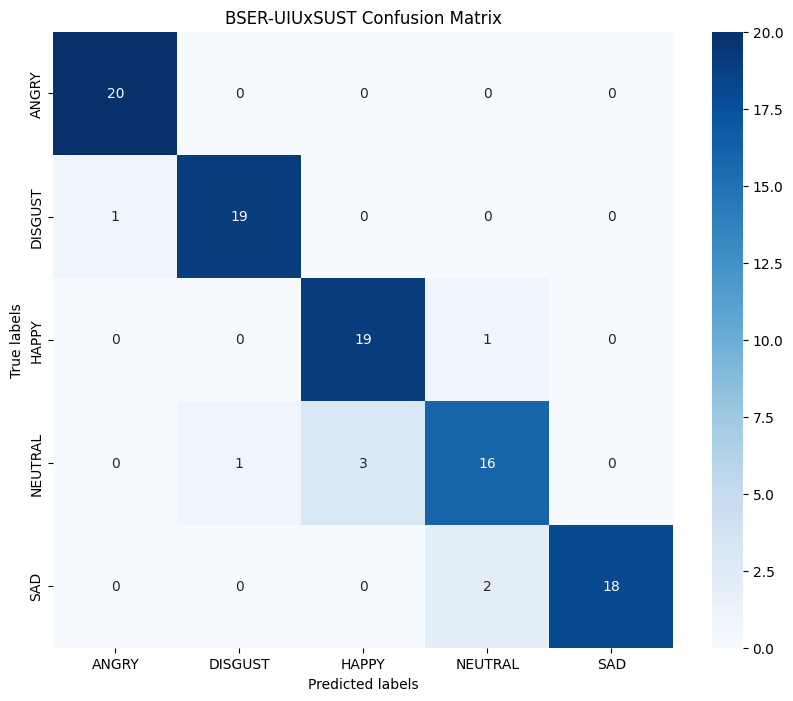

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(csv_path):
    # Load the confusion matrix from CSV
    confusion_matrix = pd.read_csv(csv_path, header=None).values

    # Define the labels for the confusion matrix
    labels = ['ANGRY', 'DISGUST', 'HAPPY', 'NEUTRAL', 'SAD']

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)

    # Add labels, title and axes
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('BSER-UIUxSUST Confusion Matrix')
    plt.show()

# Example usage
csv_path = path+'/data/BSER-UIUxSUST_confusion.csv'
plot_confusion_matrix(csv_path)
